<a href="https://colab.research.google.com/github/aekanun2020/AdvancedStat/blob/main/2025_ih_EGAT_TimeSeriesAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

การตั้งค่าเสร็จสมบูรณ์ พร้อมสำหรับการวิเคราะห์ Time Series ในระบบไฟฟ้า
สร้างชุดข้อมูลจำลองจำนวน 26281 แถว


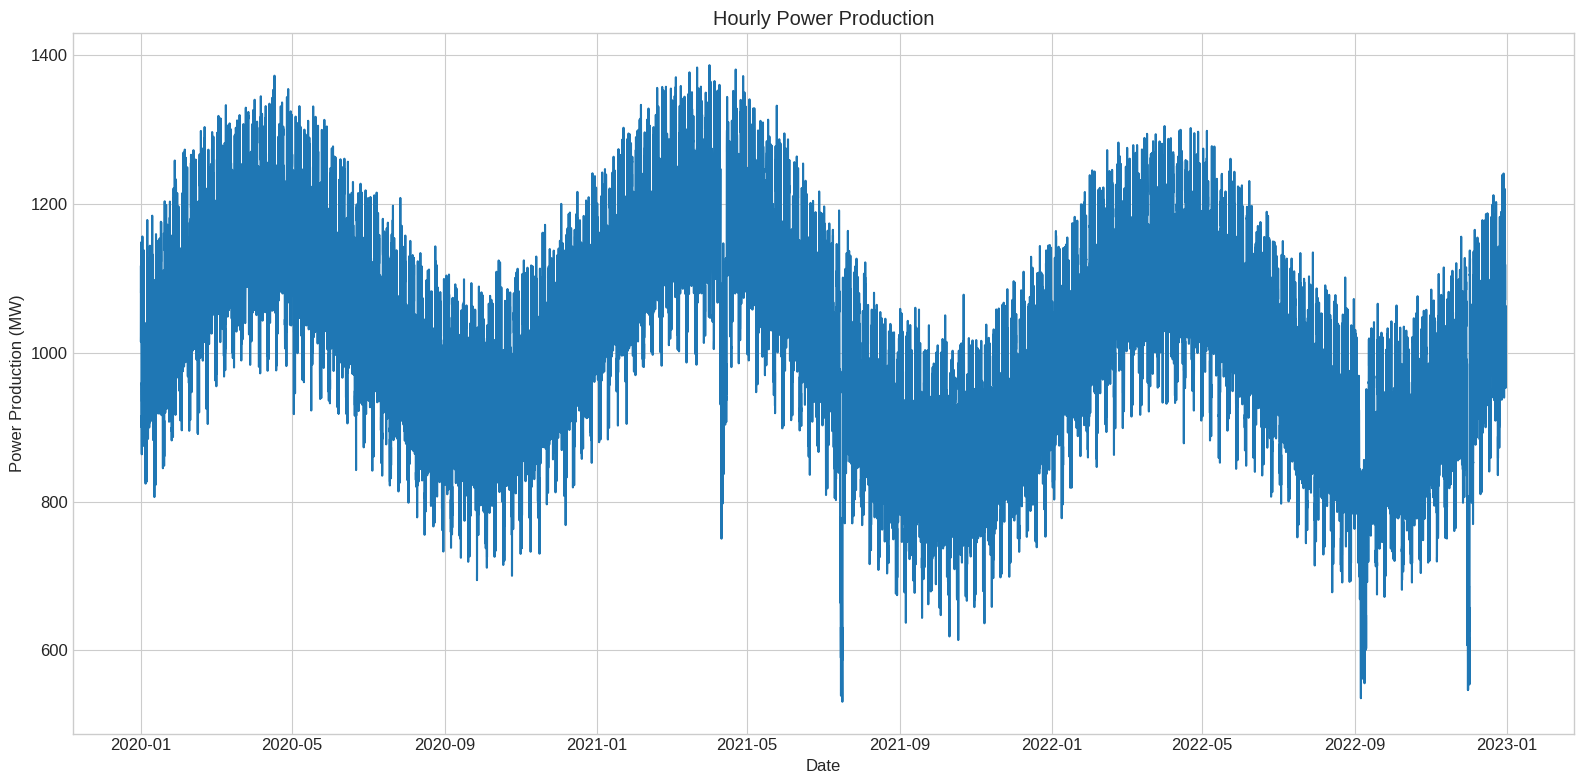

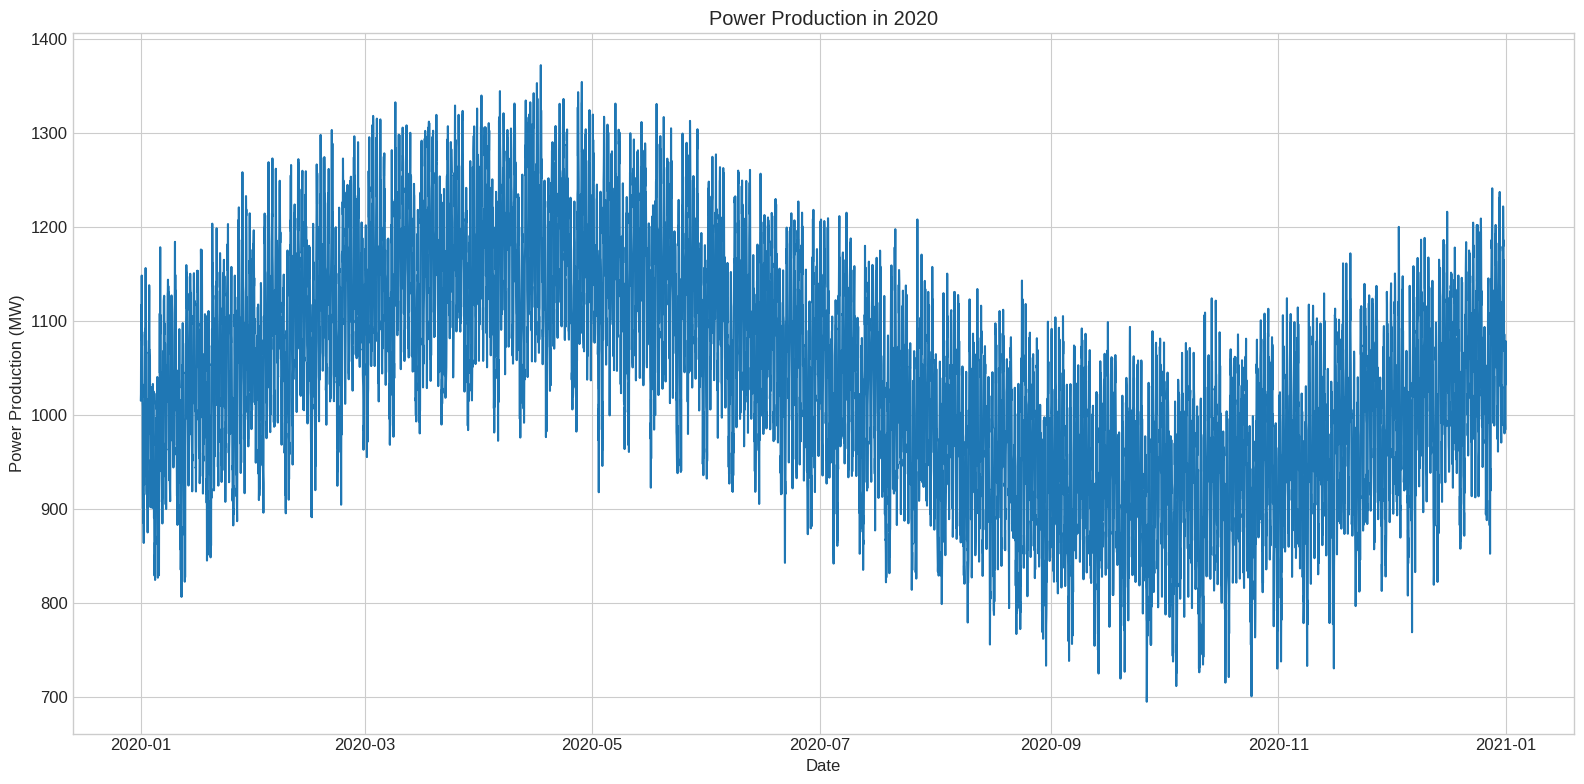

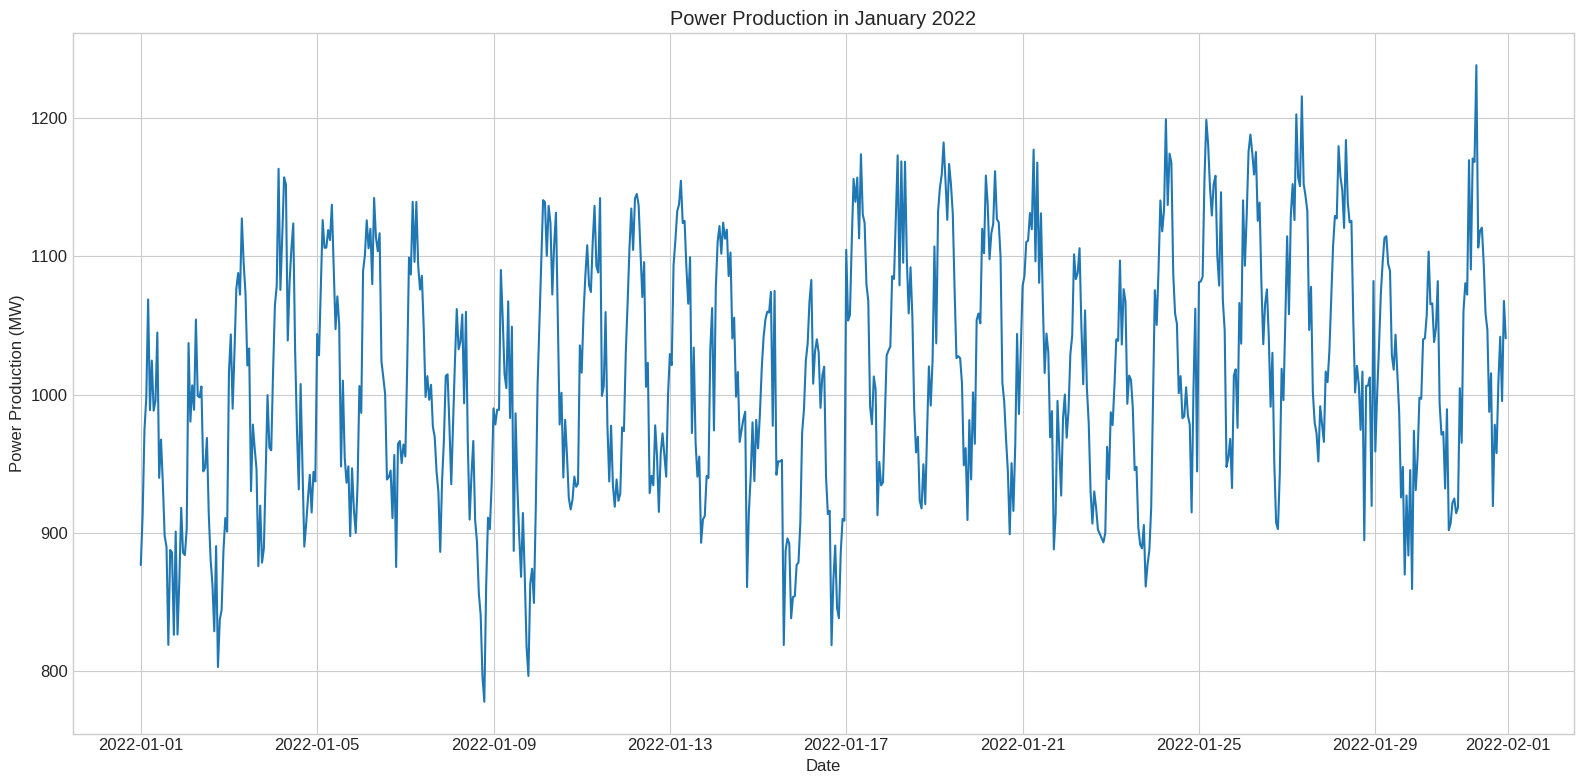

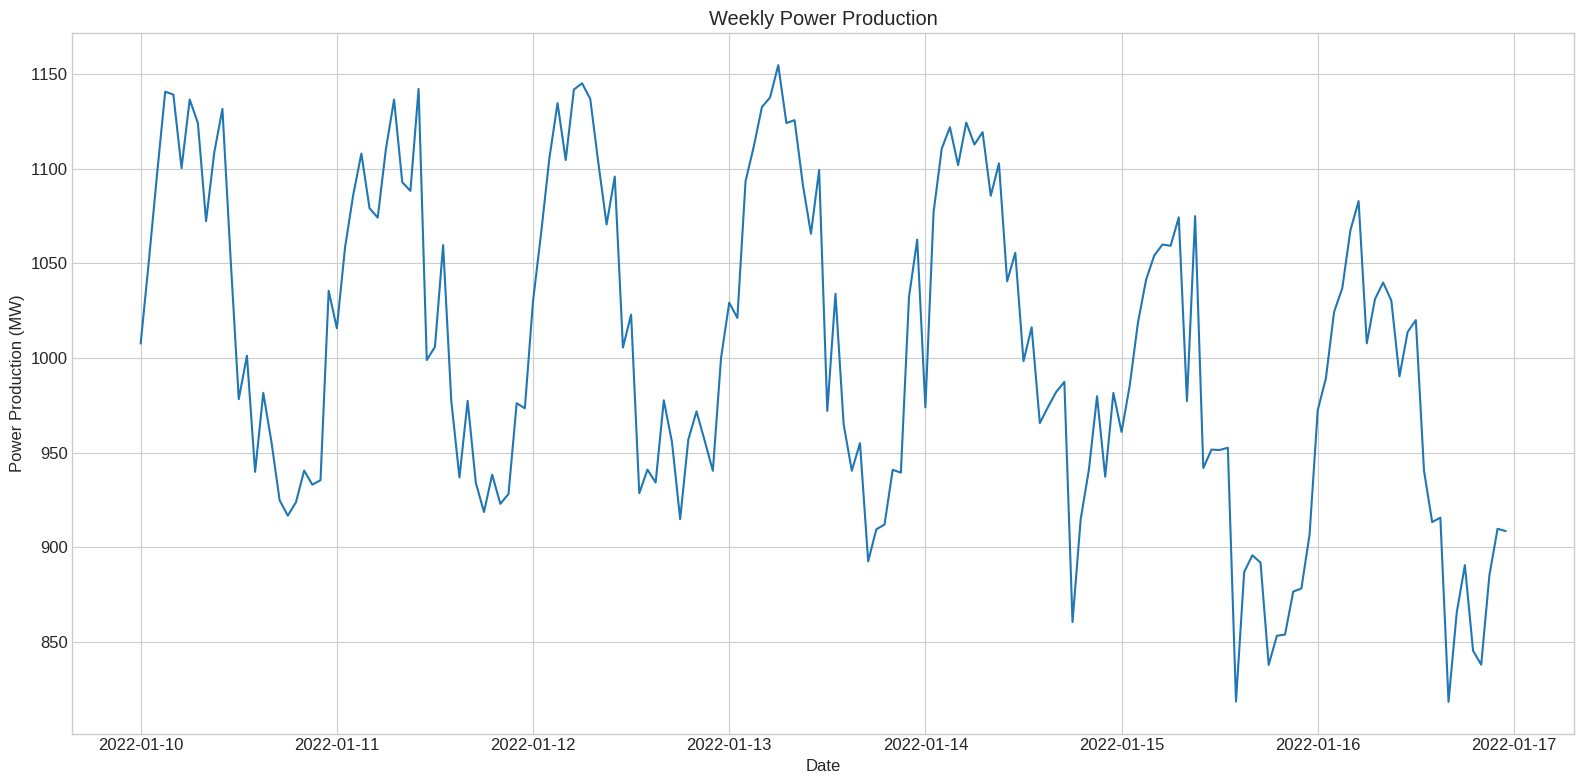

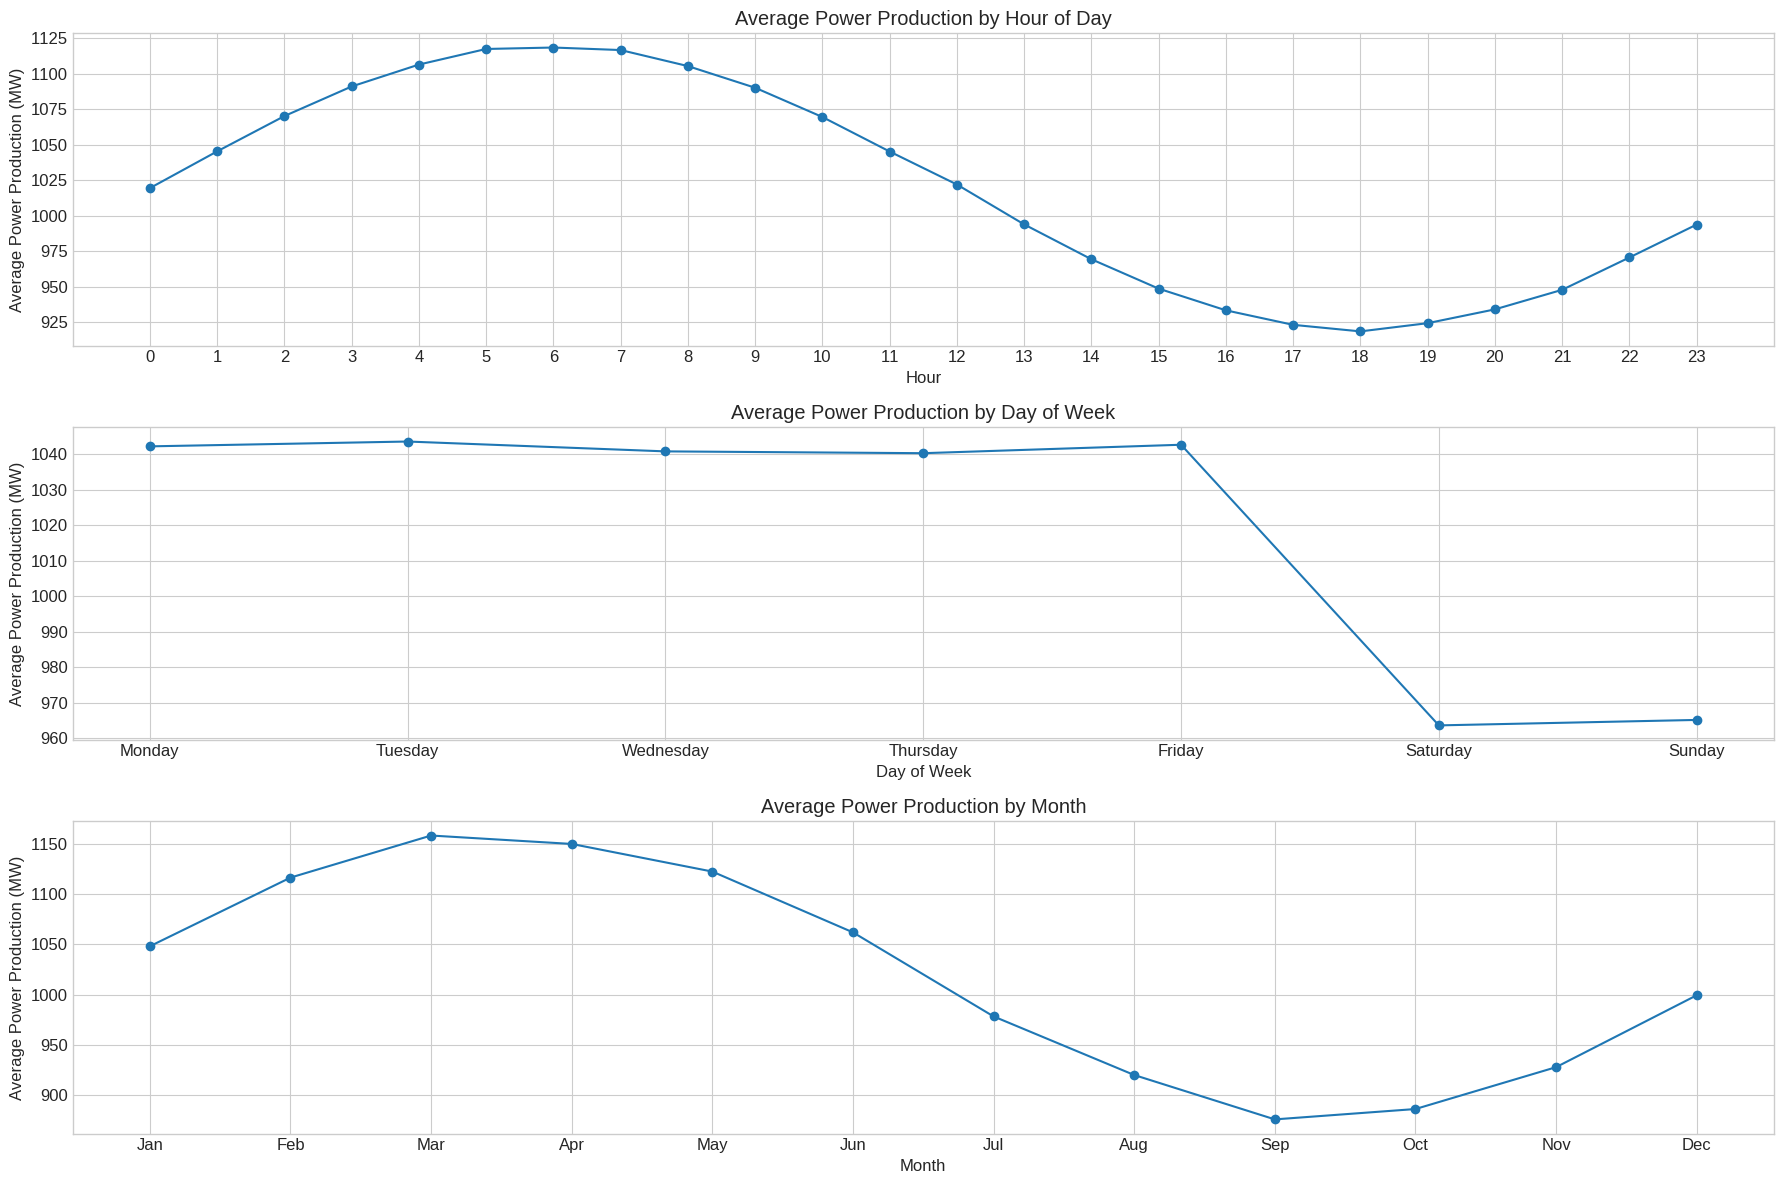

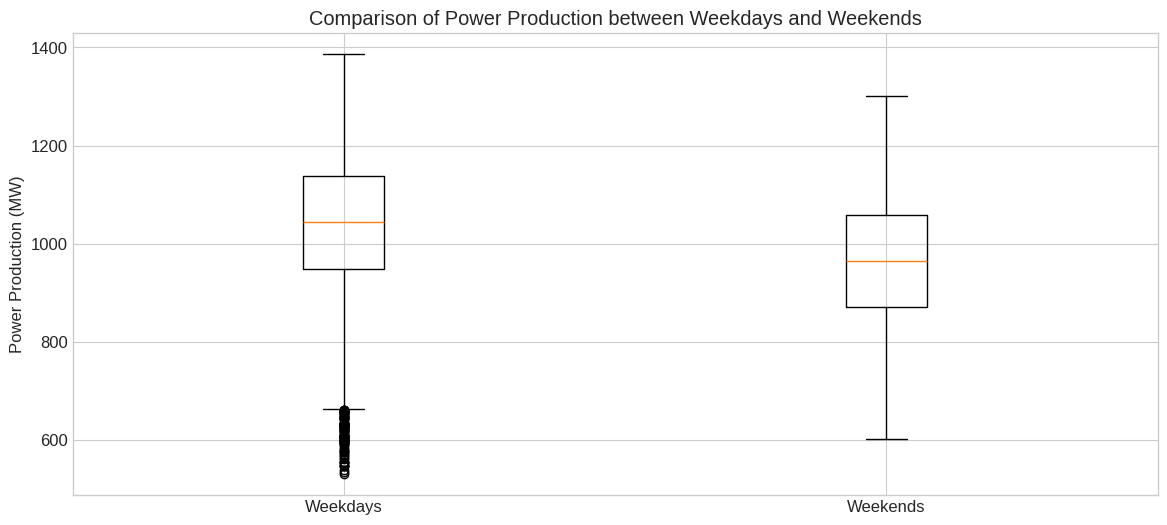

กำลังการผลิตเฉลี่ยในวันทำงาน: 1041.91 MW
กำลังการผลิตเฉลี่ยในวันหยุด: 964.39 MW
ความแตกต่างคิดเป็น: 7.44%


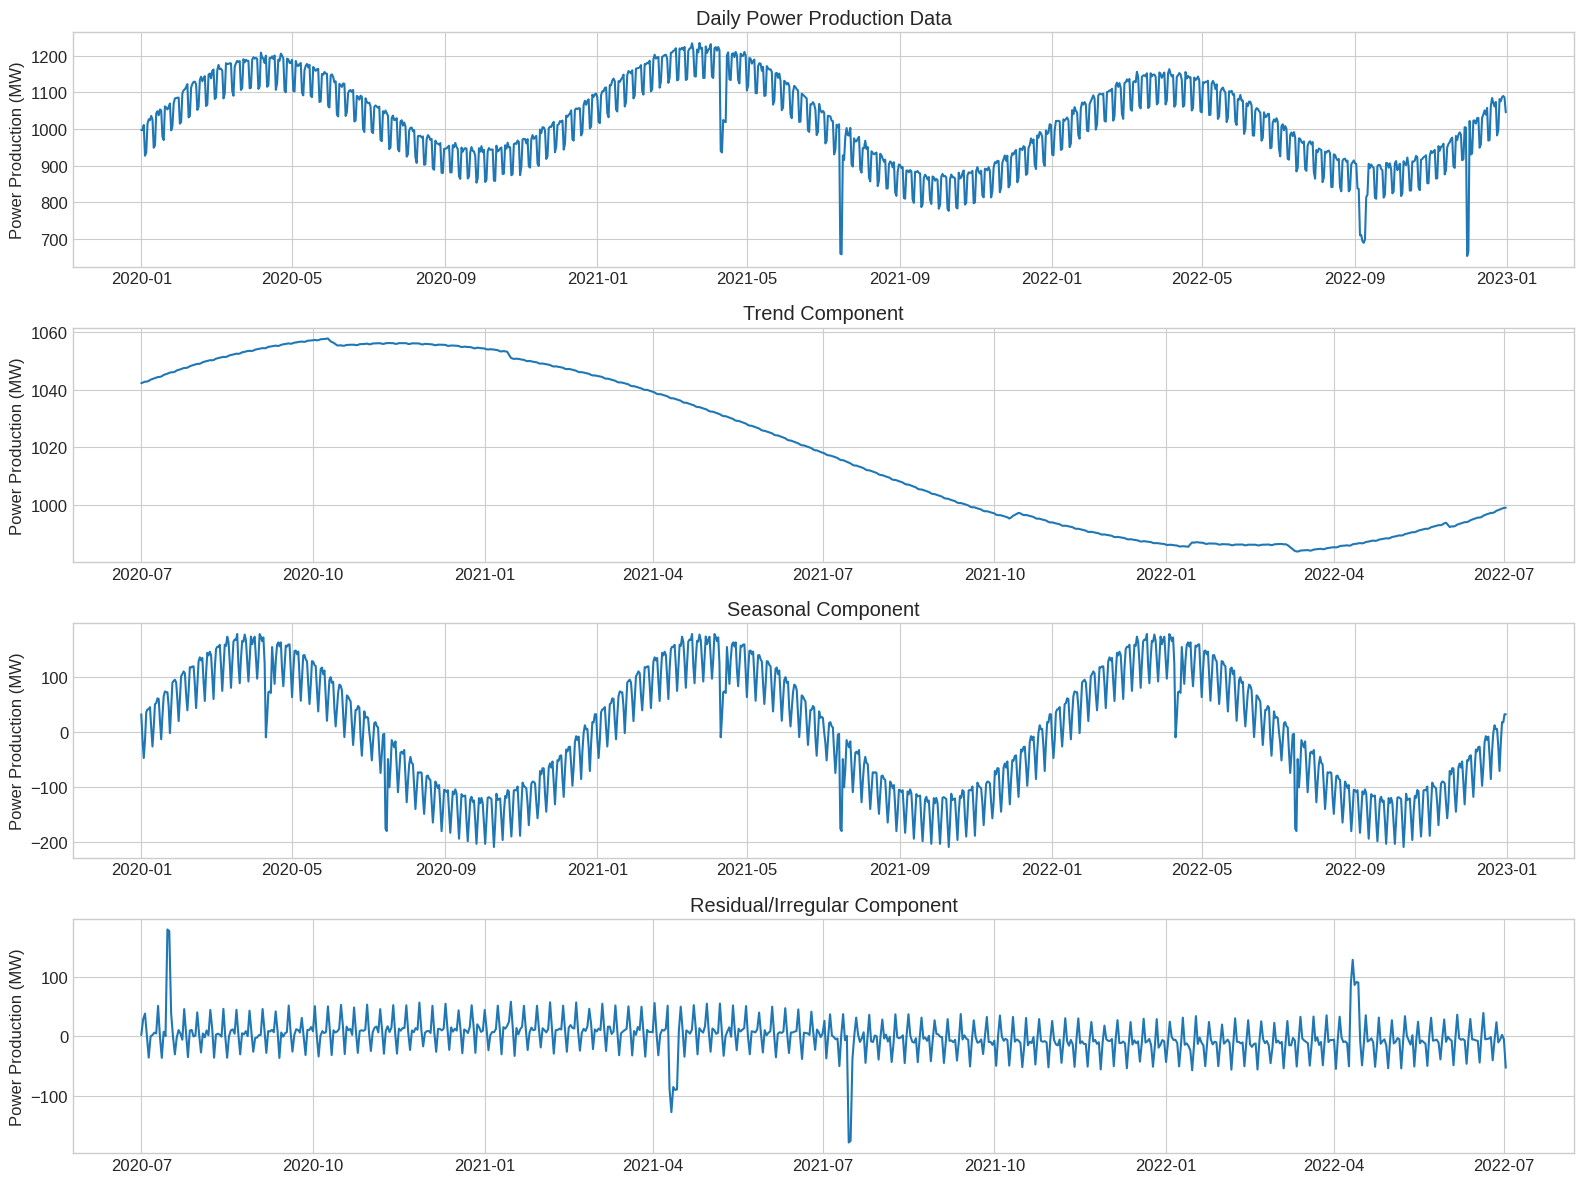

In [ ]:
# Lab 1: พื้นฐานการวิเคราะห์ Time Series และการสร้างข้อมูลจำลอง

# การติดตั้งแพ็คเกจที่จำเป็น
!pip install pandas numpy matplotlib seaborn statsmodels scikit-learn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# ปรับการแสดงผลกราฟให้สวยงาม
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 12

print("การตั้งค่าเสร็จสมบูรณ์ พร้อมสำหรับการวิเคราะห์ Time Series ในระบบไฟฟ้า")

# %% [markdown]
# ## ส่วนที่ 1: สร้างชุดข้อมูลจำลองสำหรับการผลิตไฟฟ้า
#
# ในส่วนนี้เราจะสร้างชุดข้อมูลจำลองการผลิตไฟฟ้ารายชั่วโมงที่มีองค์ประกอบของ Time Series ครบถ้วน ได้แก่:
#
# 1. **แนวโน้ม (Trend)** - การเปลี่ยนแปลงในระยะยาว
# 2. **ฤดูกาล (Seasonality)** - รูปแบบที่เกิดซ้ำในระยะเวลาที่แน่นอน
# 3. **วัฏจักร (Cyclical)** - รูปแบบที่เกิดซ้ำแต่ไม่มีระยะเวลาที่แน่นอน
# 4. **ความไม่สม่ำเสมอ (Irregular)** - ความผันผวนที่ไม่สามารถอธิบายได้ด้วยองค์ประกอบอื่น

# %%
# สร้างชุดข้อมูลจำลอง
def create_power_production_data(start_date='2020-01-01', end_date='2022-12-31'):
    # สร้างช่วงวันที่
    date_range = pd.date_range(start=start_date, end=end_date, freq='H')
    df = pd.DataFrame(index=date_range)

    # 1. แนวโน้ม (Trend) - การเติบโตของความต้องการไฟฟ้า 3% ต่อปี
    days = (df.index - df.index[0]).total_seconds() / (24*60*60)
    daily_growth = (1.03)**(1/365)  # การเติบโต 3% ต่อปี
    trend = 1000 * (daily_growth ** (days))

    # 2. ฤดูกาล (Seasonality)
    # ฤดูกาลรายปี - ความต้องการไฟฟ้าเพิ่มขึ้นในฤดูร้อนและฤดูหนาว
    yearly_seasonality = 150 * np.sin(2 * np.pi * days / 365)

    # ฤดูกาลรายวัน - สูงในช่วงกลางวัน ต่ำในช่วงกลางคืน
    hour_of_day = df.index.hour
    daily_pattern = 100 * np.sin(np.pi * hour_of_day / 12)

    # ฤดูกาลรายสัปดาห์ - ต่ำในวันหยุดสุดสัปดาห์
    day_of_week = df.index.dayofweek
    weekly_pattern = np.where(day_of_week >= 5, -80, 0)  # ลด 80 หน่วยในวันเสาร์-อาทิตย์

    # 3. วัฏจักร (Cyclical) - วัฏจักรทางเศรษฐกิจประมาณ 3 ปี
    cycle_period = 3 * 365  # วัฏจักร 3 ปี
    cyclical = 70 * np.sin(2 * np.pi * days / cycle_period)

    # 4. Irregular Component - ความผันผวนทั่วไปและเหตุการณ์พิเศษ
    np.random.seed(42)  # ตั้งค่า seed สำหรับการสร้างค่าแบบสุ่ม
    irregular = np.random.normal(0, 30, len(df))

    # เพิ่มเหตุการณ์พิเศษบางวัน (เช่น ไฟดับหรือซ่อมบำรุงโรงไฟฟ้า)
    special_events = pd.Series(0, index=df.index)
    # สมมติว่ามีการซ่อมบำรุงโรงไฟฟ้าในบางช่วง
    maintenance_periods = [
        ('2021-04-10', '2021-04-15'),
        ('2022-09-05', '2022-09-10')
    ]

    for start, end in maintenance_periods:
        mask = (df.index >= start) & (df.index <= end)
        special_events[mask] = -200  # ลดการผลิตลง 200 หน่วย

    # สมมติว่ามีเหตุการณ์ฉุกเฉินทำให้โรงไฟฟ้าหยุดทำงานชั่วคราว
    emergency_dates = ['2021-07-15', '2022-11-30']
    for date in emergency_dates:
        # ส่งผลกระทบ 48 ชั่วโมง
        start_date = pd.Timestamp(date)
        end_date = start_date + pd.Timedelta(hours=48)
        mask = (df.index >= start_date) & (df.index < end_date)
        special_events[mask] = -350  # ลดการผลิตลง 350 หน่วย

    # รวมองค์ประกอบทั้งหมด
    df['power_production'] = trend + yearly_seasonality + daily_pattern + weekly_pattern + cyclical + irregular + special_events

    # ปรับให้ค่าต่ำสุดไม่น้อยกว่า 100 (กำลังการผลิตขั้นต่ำ)
    df['power_production'] = df['power_production'].clip(lower=100)

    # เพิ่มคอลัมน์ข้อมูลเวลาที่ง่ายต่อการวิเคราะห์
    df['hour'] = df.index.hour
    df['day'] = df.index.day
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['day_of_week'] = df.index.dayofweek
    df['weekend'] = df['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)

    return df

# สร้างข้อมูล
power_data = create_power_production_data()
print(f"สร้างชุดข้อมูลจำลองจำนวน {len(power_data)} แถว")
power_data.head()

# %% [markdown]
# ## ส่วนที่ 2: การแสดงผลข้อมูลและการวิเคราะห์เบื้องต้น
#
# ในส่วนนี้ เราจะวิเคราะห์และแสดงผลข้อมูลที่สร้างขึ้นในรูปแบบต่างๆ เพื่อให้เข้าใจลักษณะข้อมูลมากขึ้น

# %%
# แสดงกราฟชุดข้อมูลทั้งหมด
def plot_time_series(df, column='power_production', title='Hourly Power Production'):
    plt.figure(figsize=(16, 8))
    plt.plot(df.index, df[column])
    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('Power Production (MW)')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# แสดงกราฟชุดข้อมูลทั้งหมด
plot_time_series(power_data)

# แสดงข้อมูลในรอบปีแรก
plot_time_series(power_data.loc['2020-01-01':'2020-12-31'], title='Power Production in 2020')

# แสดงข้อมูลรายเดือน (เลือกเดือนมกราคม 2022)
plot_time_series(power_data.loc['2022-01-01':'2022-01-31'], title='Power Production in January 2022')

# แสดงข้อมูลรายสัปดาห์ (เลือก 1 สัปดาห์)
plot_time_series(power_data.loc['2022-01-10':'2022-01-16'], title='Weekly Power Production')

# %% [markdown]
# ## ส่วนที่ 3: การวิเคราะห์รูปแบบตามช่วงเวลา
#
# ในส่วนนี้ เราจะวิเคราะห์รูปแบบการผลิตไฟฟ้าตามช่วงเวลาต่างๆ เช่น ตามชั่วโมง วันในสัปดาห์ และเดือน

# %%
# วิเคราะห์รูปแบบการผลิตไฟฟ้าตามช่วงเวลา
hourly_pattern = power_data.groupby(power_data.index.hour)['power_production'].mean()
daily_pattern = power_data.groupby(power_data.index.dayofweek)['power_production'].mean()
monthly_pattern = power_data.groupby(power_data.index.month)['power_production'].mean()

# แสดงรูปแบบการผลิตไฟฟ้า
plt.figure(figsize=(18, 12))

plt.subplot(3, 1, 1)
plt.plot(hourly_pattern.index, hourly_pattern.values, marker='o')
plt.title('Average Power Production by Hour of Day')
plt.xlabel('Hour')
plt.ylabel('Average Power Production (MW)')
plt.xticks(range(0, 24))
plt.grid(True)

plt.subplot(3, 1, 2)
plt.plot(daily_pattern.index, daily_pattern.values, marker='o')
plt.title('Average Power Production by Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Average Power Production (MW)')
plt.xticks(range(0, 7), ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.grid(True)

plt.subplot(3, 1, 3)
plt.plot(monthly_pattern.index, monthly_pattern.values, marker='o')
plt.title('Average Power Production by Month')
plt.xlabel('Month')
plt.ylabel('Average Power Production (MW)')
plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.grid(True)

plt.tight_layout()
plt.show()

# วิเคราะห์ความแตกต่างระหว่างวันทำงานและวันหยุด
workday_data = power_data[power_data['weekend'] == 0]['power_production']
weekend_data = power_data[power_data['weekend'] == 1]['power_production']

plt.figure(figsize=(14, 6))
plt.boxplot([workday_data, weekend_data], labels=['Weekdays', 'Weekends'])
plt.title('Comparison of Power Production between Weekdays and Weekends')
plt.ylabel('Power Production (MW)')
plt.grid(True)
plt.show()

# คำนวณความแตกต่างทางสถิติ
workday_mean = workday_data.mean()
weekend_mean = weekend_data.mean()
difference_percent = (workday_mean - weekend_mean) / workday_mean * 100

print(f"กำลังการผลิตเฉลี่ยในวันทำงาน: {workday_mean:.2f} MW")
print(f"กำลังการผลิตเฉลี่ยในวันหยุด: {weekend_mean:.2f} MW")
print(f"ความแตกต่างคิดเป็น: {difference_percent:.2f}%")

# %% [markdown]
# ## ส่วนที่ 4: การแยกองค์ประกอบของ Time Series
#
# ในส่วนนี้เราจะแยกองค์ประกอบของ Time Series ออกเป็น:
# 1. แนวโน้ม (Trend)
# 2. ฤดูกาล (Seasonality)
# 3. สิ่งที่เหลือ/องค์ประกอบไม่สม่ำเสมอ (Residual/Irregular)

# %%
# สำหรับการแยกองค์ประกอบ ให้ดาวน์แซมเปิลข้อมูลเป็นรายวัน
daily_data = power_data['power_production'].resample('D').mean()

# แยกองค์ประกอบ Time Series ด้วย statsmodels
decomposition = seasonal_decompose(daily_data, model='additive', period=365)

# แสดงผลลัพธ์
plt.figure(figsize=(16, 12))

plt.subplot(4, 1, 1)
plt.plot(decomposition.observed)
plt.title('Daily Power Production Data')
plt.ylabel('Power Production (MW)')

plt.subplot(4, 1, 2)
plt.plot(decomposition.trend)
plt.title('Trend Component')
plt.ylabel('Power Production (MW)')

plt.subplot(4, 1, 3)
plt.plot(decomposition.seasonal)
plt.title('Seasonal Component')
plt.ylabel('Power Production (MW)')

plt.subplot(4, 1, 4)
plt.plot(decomposition.resid)
plt.title('Residual/Irregular Component')
plt.ylabel('Power Production (MW)')

plt.tight_layout()
plt.show()

# %% [markdown]
# ## สรุป Lab 1
#
# ในแล็บนี้ เราได้เรียนรู้:
#
# 1. **การสร้างข้อมูลจำลอง** - สร้างชุดข้อมูลการผลิตไฟฟ้าที่มีองค์ประกอบของ Time Series ครบถ้วน
# 2. **การแสดงผลและวิเคราะห์เบื้องต้น** - ดูภาพรวมของข้อมูลในหลายระดับเวลา
# 3. **การวิเคราะห์รูปแบบตามช่วงเวลา** - เข้าใจรูปแบบการผลิตไฟฟ้าตามชั่วโมง วัน และเดือน
# 4. **การแยกองค์ประกอบ Time Series** - แยกองค์ประกอบหลักออกจากกันเพื่อวิเคราะห์อย่างละเอียด
#
# ในแล็บถัดไป เราจะศึกษาเรื่องการทำให้ข้อมูล Time Series เป็นข้อมูลคงที่ (Stationarity) และการใช้เทคนิค Moving Averages